In [1]:
# Imports
import pandas as pd
import datetime as dt

import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, callbacks
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
from imblearn.over_sampling import SMOTE 

In [2]:
atg_obs = pd.read_csv('../../Downloads/LFEM_data-.csv', low_memory=False, skiprows=1)
atg_obs.insert(0, 'datetime_UTC', pd.to_datetime(atg_obs['Date'] + atg_obs['Time'], format='%Y-%m-%d%H:%M'))
# atg_obs_selected = atg_obs.loc[(atg_obs['datetime_UTC']>=dt.datetime(2020,5,1))].copy() # Selecting dates

In [3]:
atg_obs_selected = atg_obs.copy() # Selecting dates

In [4]:
atg_obs_selected = atg_obs_selected.loc[(atg_obs['datetime_UTC']>=dt.datetime(2023,5,1))]

In [5]:
atg_obs_selected

,datetime_UTC,Pseudo-Julian-Date,Date,Time,Temperature,Dewpoint,Relhum,Speed,Gust,Direction,Pressure,Solar,SumRain,Rain
10815027,2020-05-01 00:00:00,2.458971e+06,2020-05-01,00:00,55.600000,40.900000,57.7,12.200000,17.000000,208,1015.2,399.9,796.27,0.00
10815028,2020-05-01 00:01:00,2.458971e+06,2020-05-01,00:01,55.600000,40.800000,57.3,11.800000,15.400000,208,1015.2,409.8,796.27,0.00
10815029,2020-05-01 00:02:00,2.458971e+06,2020-05-01,00:02,55.700000,41.000000,57.6,9.400000,14.700000,205,1015.2,414.7,796.27,0.00
10815030,2020-05-01 00:03:00,2.458971e+06,2020-05-01,00:03,55.900000,41.100000,57.3,14.900000,18.500000,209,1015.2,415.2,796.27,0.00
10815031,2020-05-01 00:04:00,2.458971e+06,2020-05-01,00:04,55.900000,41.000000,57.1,12.300000,17.000000,217,1015.1,404.3,796.27,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12941709,2024-05-23 17:52:00,2.460455e+06,2024-05-23,17:52,54.200000,42.000000,63.1,7.400000,10.800000,143,1017.2,225.6,969.65,0.00
12941710,2024-05-23 17:53:00,2.460455e+06,2024-05-23,17:53,54.200000,41.900000,63.0,12.300000,15.300000,153,1017.2,224.1,969.65,0.00
12941711,2024-05-23 17:54:00,2.460455e+06,2024-05-23,17:54,54.200000,41.800000,62.7,12.600000,14.400000,147,1017.2,223.6,969.65,0.00
12941712,2024-05-23 17:55:00,2.460455e+06,2024-05-23,17:55,54.100000,41.900000,63.1,10.700000,12.600000,125,1017.2,225.3,969.65,0.00


In [6]:
no_erros_obs = atg_obs_selected.loc[(atg_obs_selected['Rain']!='M')&(atg_obs_selected['Temperature']!='M')&(atg_obs_selected['Pressure']!='M')&(atg_obs_selected['Relhum']!='M')&(atg_obs_selected['Relhum']!='0.00.')].copy()
no_erros_obs['Rain'] = no_erros_obs['Rain'].astype(float)
no_erros_obs['Temperature'] = no_erros_obs['Temperature'].astype(float)
no_erros_obs['Pressure'] = no_erros_obs['Pressure'].astype(float)
no_erros_obs['Relhum'] = no_erros_obs['Relhum'].astype(float)

In [7]:
no_erros_obs

,datetime_UTC,Pseudo-Julian-Date,Date,Time,Temperature,Dewpoint,Relhum,Speed,Gust,Direction,Pressure,Solar,SumRain,Rain
10815027,2020-05-01 00:00:00,2.458971e+06,2020-05-01,00:00,55.6,40.900000,57.7,12.200000,17.000000,208,1015.2,399.9,796.27,0.0
10815028,2020-05-01 00:01:00,2.458971e+06,2020-05-01,00:01,55.6,40.800000,57.3,11.800000,15.400000,208,1015.2,409.8,796.27,0.0
10815029,2020-05-01 00:02:00,2.458971e+06,2020-05-01,00:02,55.7,41.000000,57.6,9.400000,14.700000,205,1015.2,414.7,796.27,0.0
10815030,2020-05-01 00:03:00,2.458971e+06,2020-05-01,00:03,55.9,41.100000,57.3,14.900000,18.500000,209,1015.2,415.2,796.27,0.0
10815031,2020-05-01 00:04:00,2.458971e+06,2020-05-01,00:04,55.9,41.000000,57.1,12.300000,17.000000,217,1015.1,404.3,796.27,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12941709,2024-05-23 17:52:00,2.460455e+06,2024-05-23,17:52,54.2,42.000000,63.1,7.400000,10.800000,143,1017.2,225.6,969.65,0.0
12941710,2024-05-23 17:53:00,2.460455e+06,2024-05-23,17:53,54.2,41.900000,63.0,12.300000,15.300000,153,1017.2,224.1,969.65,0.0
12941711,2024-05-23 17:54:00,2.460455e+06,2024-05-23,17:54,54.2,41.800000,62.7,12.600000,14.400000,147,1017.2,223.6,969.65,0.0
12941712,2024-05-23 17:55:00,2.460455e+06,2024-05-23,17:55,54.1,41.900000,63.1,10.700000,12.600000,125,1017.2,225.3,969.65,0.0


In [8]:
first_obs_each_period = no_erros_obs.resample(on='datetime_UTC', rule='1h')
first_obs_each_period

In [9]:
summed_rain_each_period = first_obs_each_period['Rain'].sum()
summed_rain_each_period

datetime_UTC
2020-05-01 00:00:00    0.0
2020-05-01 01:00:00    0.0
2020-05-01 02:00:00    0.0
2020-05-01 03:00:00    0.0
2020-05-01 04:00:00    0.0
                      ... 
2024-05-23 13:00:00    0.0
2024-05-23 14:00:00    0.0
2024-05-23 15:00:00    0.0
2024-05-23 16:00:00    0.0
2024-05-23 17:00:00    0.0
Freq: h, Name: Rain, Length: 35610, dtype: float64

In [10]:
summed_rain_each_period[-48:-24]

datetime_UTC
2024-05-21 18:00:00    0.08
2024-05-21 19:00:00    0.06
2024-05-21 20:00:00    0.00
2024-05-21 21:00:00    0.01
2024-05-21 22:00:00    0.05
2024-05-21 23:00:00    0.09
2024-05-22 00:00:00    0.09
2024-05-22 01:00:00    0.03
2024-05-22 02:00:00    0.00
2024-05-22 03:00:00    0.00
2024-05-22 04:00:00    0.00
2024-05-22 05:00:00    0.00
2024-05-22 06:00:00    0.00
2024-05-22 07:00:00    0.00
2024-05-22 08:00:00    0.02
2024-05-22 09:00:00    0.15
2024-05-22 10:00:00    0.11
2024-05-22 11:00:00    0.07
2024-05-22 12:00:00    0.00
2024-05-22 13:00:00    0.00
2024-05-22 14:00:00    0.00
2024-05-22 15:00:00    0.00
2024-05-22 16:00:00    0.00
2024-05-22 17:00:00    0.00
Freq: h, Name: Rain, dtype: float64

In [11]:
lightrainfall_times = summed_rain_each_period[(summed_rain_each_period<=0.10)&(summed_rain_each_period>0.0)]
# moderaterainfall_times = summed_rain_each_period[(summed_rain_each_period<=0.30)&(summed_rain_each_period>0.10)]
heavyrainfall_times = summed_rain_each_period[(summed_rain_each_period>0.10)]

any_rainfall_times = summed_rain_each_period[(summed_rain_each_period>0.0)]

summed_rain_each_period.loc[lightrainfall_times.index] = 1
summed_rain_each_period.loc[heavyrainfall_times.index] = 2
# summed_rain_each_period.loc[any_rainfall_times.index] = 1

In [12]:
# Extract Date, Time, Temperature, SumRain into data array
atg_obs_necessary = pd.DataFrame()
atg_obs_necessary['date'] = first_obs_each_period['Date'].first()
atg_obs_necessary['time'] = first_obs_each_period['Time'].first()
atg_obs_necessary['temperature'] = first_obs_each_period['Temperature'].first()
atg_obs_necessary['pressure'] = first_obs_each_period['Pressure'].first()
atg_obs_necessary['relhum'] = first_obs_each_period['Relhum'].first()
atg_obs_necessary['rainfall_type'] = summed_rain_each_period

data_arr = atg_obs_necessary.values
atg_obs_necessary

,date,time,temperature,pressure,relhum,rainfall_type
datetime_UTC,,,,,,
2020-05-01 00:00:00,2020-05-01,00:00,55.6,1015.2,57.7,0.0
2020-05-01 01:00:00,2020-05-01,01:00,55.8,1015.4,53.3,0.0
2020-05-01 02:00:00,2020-05-01,02:00,54.1,1015.6,56.9,0.0
2020-05-01 03:00:00,2020-05-01,03:00,53.5,1015.8,61.1,0.0
2020-05-01 04:00:00,2020-05-01,04:00,52.1,1016.5,65.7,0.0
...,...,...,...,...,...,...
2024-05-23 13:00:00,2024-05-23,13:00,50.5,1016.5,77.4,0.0
2024-05-23 14:00:00,2024-05-23,14:00,51.7,1016.8,74.0,0.0
2024-05-23 15:00:00,2024-05-23,15:00,52.4,1017.0,69.1,0.0


In [13]:
atg_obs_necessary.iloc[len(atg_obs_necessary)-48:,:]

,date,time,temperature,pressure,relhum,rainfall_type
datetime_UTC,,,,,,
2024-05-21 18:00:00,2024-05-21,18:00,50.4,1014.1,93.9,1.0
2024-05-21 19:00:00,2024-05-21,19:00,51.2,1013.3,92.6,1.0
2024-05-21 20:00:00,2024-05-21,20:00,51.3,1012.7,91.7,0.0
2024-05-21 21:00:00,2024-05-21,21:00,52.1,1012.1,89.5,1.0
2024-05-21 22:00:00,2024-05-21,22:00,52.3,1011.3,91.3,1.0
2024-05-21 23:00:00,2024-05-21,23:00,52.6,1010.5,91.7,1.0
2024-05-22 00:00:00,2024-05-22,00:00,52.4,1010.1,92.1,1.0
2024-05-22 01:00:00,2024-05-22,01:00,52.5,1009.5,92.4,1.0
2024-05-22 02:00:00,2024-05-22,02:00,52.9,1008.8,91.4,0.0


In [14]:
atg_obs_necessary.loc[atg_obs_necessary['rainfall_type']==2]

,date,time,temperature,pressure,relhum,rainfall_type
datetime_UTC,,,,,,
2020-05-17 05:00:00,2020-05-17,05:00,56.6,1001.8,84.1,2.0
2020-05-17 06:00:00,2020-05-17,06:00,55.3,1002.5,88.2,2.0
2020-05-21 11:00:00,2020-05-21,11:00,48.7,1012.9,83.7,2.0
2020-05-21 12:00:00,2020-05-21,12:00,47.8,1012.5,86.6,2.0
2020-05-23 02:00:00,2020-05-23,02:00,54.7,1015.5,73.2,2.0
...,...,...,...,...,...,...
2024-04-30 01:00:00,2024-04-30,01:00,47.9,1014.4,76.0,2.0
2024-05-07 07:00:00,2024-05-07,07:00,46.0,1013.1,91.5,2.0
2024-05-19 11:00:00,2024-05-19,11:00,48.6,1017.7,88.1,2.0


In [15]:
notable_event_times = atg_obs_necessary.loc[atg_obs_necessary['rainfall_type']>=2].index

relevant_times = pd.DataFrame()
for event_time in notable_event_times:
    start_time = event_time-pd.Timedelta(days=30)
    end_time = event_time+pd.Timedelta(days=30)
    # event_time = notable_event_times[1]
    if not((start_time in relevant_times.index)) and not((end_time in relevant_times.index)):
        time_around_event = atg_obs_necessary.loc[start_time:end_time].copy()
        relevant_times = pd.concat([relevant_times, time_around_event])
relevant_times

,date,time,temperature,pressure,relhum,rainfall_type
datetime_UTC,,,,,,
2020-05-01 00:00:00,2020-05-01,00:00,55.6,1015.2,57.7,0.0
2020-05-01 01:00:00,2020-05-01,01:00,55.8,1015.4,53.3,0.0
2020-05-01 02:00:00,2020-05-01,02:00,54.1,1015.6,56.9,0.0
2020-05-01 03:00:00,2020-05-01,03:00,53.5,1015.8,61.1,0.0
2020-05-01 04:00:00,2020-05-01,04:00,52.1,1016.5,65.7,0.0
...,...,...,...,...,...,...
2024-05-23 13:00:00,2024-05-23,13:00,50.5,1016.5,77.4,0.0
2024-05-23 14:00:00,2024-05-23,14:00,51.7,1016.8,74.0,0.0
2024-05-23 15:00:00,2024-05-23,15:00,52.4,1017.0,69.1,0.0


In [16]:
notable_event_times

DatetimeIndex(['2020-05-17 05:00:00', '2020-05-17 06:00:00',
               '2020-05-21 11:00:00', '2020-05-21 12:00:00',
               '2020-05-23 02:00:00', '2020-05-30 16:00:00',
               '2020-05-30 23:00:00', '2020-05-31 00:00:00',
               '2020-05-31 01:00:00', '2020-06-14 03:00:00',
               ...
               '2024-03-22 04:00:00', '2024-04-03 05:00:00',
               '2024-04-03 06:00:00', '2024-04-29 11:00:00',
               '2024-04-30 00:00:00', '2024-04-30 01:00:00',
               '2024-05-07 07:00:00', '2024-05-19 11:00:00',
               '2024-05-22 09:00:00', '2024-05-22 10:00:00'],
              dtype='datetime64[ns]', name='datetime_UTC', length=356, freq=None)

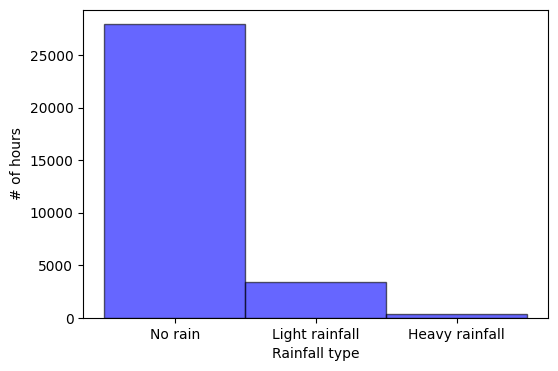

(array([27907,  3437,   344]), array([0., 1., 2., 3.]))

In [17]:
rain_counts, classes = np.histogram(relevant_times['rainfall_type'].values, bins=np.arange(0,relevant_times['rainfall_type'].max()+2))

plt.figure(figsize=(6,4))
# plt.title(f'Hours where it rained at least {rain_thresh} inches')
plt.bar(x=np.arange(0,relevant_times['rainfall_type'].max()+1), width=1, height=rain_counts, facecolor='blue', edgecolor='k', alpha=0.6)
plt.ylabel('# of hours')
plt.xticks(ticks=np.arange(0,relevant_times['rainfall_type'].max()+1), labels=['No rain', 'Light rainfall', 'Heavy rainfall'])
plt.xlabel('Rainfall type')
# plt.yscale('log')
plt.show()
rain_counts, classes

In [18]:
train_val_times, test_times = train_test_split(relevant_times,random_state=42,test_size=0.2)

In [19]:
train_times, val_times = train_test_split(train_val_times,random_state=42,test_size=0.25)

In [20]:
train_times

,date,time,temperature,pressure,relhum,rainfall_type
datetime_UTC,,,,,,
2023-09-11 14:00:00,2023-09-11,14:00,62.9,1013.6,76.1,0.0
2020-05-01 22:00:00,2020-05-01,22:00,61.9,1012.6,32.7,0.0
2020-06-23 17:00:00,2020-06-23,17:00,69.2,1013.1,49.0,0.0
2020-06-18 15:00:00,2020-06-18,15:00,57.7,1020.8,71.3,0.0
2023-05-08 23:00:00,2023-05-08,23:00,64.5,1010.4,45.7,0.0
...,...,...,...,...,...,...
2020-06-17 00:00:00,2020-06-17,00:00,66.0,1015.7,33.8,0.0
2020-05-28 20:00:00,2020-05-28,20:00,71.0,1012.4,36.5,0.0
2022-03-13 08:00:00,2022-03-13,08:00,47.1,1000.6,77.1,1.0


In [21]:
val_times

,date,time,temperature,pressure,relhum,rainfall_type
datetime_UTC,,,,,,
2020-06-28 11:00:00,2020-06-28,11:00,53.3,1006.9,87.3,1.0
2020-05-17 06:00:00,2020-05-17,06:00,55.3,1002.5,88.2,2.0
2022-12-18 08:00:00,2022-12-18,08:00,40.1,1011.1,89.6,0.0
2020-09-13 18:00:00,2020-09-13,18:00,57.5,1009.8,84.7,0.0
2023-03-29 22:00:00,2023-03-29,22:00,58.7,1005.2,29.3,0.0
...,...,...,...,...,...,...
2020-06-15 00:00:00,2020-06-15,00:00,62.2,1012.5,41.9,0.0
2020-05-31 18:00:00,2020-05-31,18:00,51.0,1014.5,84.7,0.0
2020-10-25 06:00:00,2020-10-25,06:00,42.6,1025.6,55.2,0.0


In [22]:
test_times

,date,time,temperature,pressure,relhum,rainfall_type
datetime_UTC,,,,,,
2021-09-01 19:00:00,2021-09-01,19:00,62.8,1013.5,49.3,0.0
2021-04-23 22:00:00,2021-04-23,22:00,58.4,1008.6,47.8,0.0
2021-11-18 07:00:00,2021-11-18,07:00,46.0,1012.8,37.5,0.0
2021-10-30 06:00:00,2021-10-30,06:00,44.7,1020.3,67.5,0.0
2020-06-12 04:00:00,2020-06-12,04:00,67.0,1012.5,55.5,0.0
...,...,...,...,...,...,...
2021-09-17 19:00:00,2021-09-17,19:00,54.9,1004.3,77.3,1.0
2020-06-20 15:00:00,2020-06-20,15:00,63.3,1010.0,63.0,1.0
2021-12-15 17:00:00,2021-12-15,17:00,42.4,1004.0,54.6,0.0


In [23]:
def get_processed_df_from_data(dataset):
    date_objs = pd.to_datetime(dataset['date'], format="%Y-%m-%d")
    time_objs = pd.to_datetime(dataset['time'], format='%H:%M')

    days_of_year = pd.DatetimeIndex(date_objs).dayofyear
    months = pd.DatetimeIndex(date_objs).month
    times_in_hours_from_zero = (pd.DatetimeIndex(time_objs).hour + (pd.DatetimeIndex(time_objs).minute/60))
    hours = pd.DatetimeIndex(time_objs).hour

    processed_df = pd.DataFrame()
    processed_df['months_from_july'] = (np.abs(months - 7))
    # processed_df['month'] = months
    processed_df['time_of_day'] = ((hours-8)%24) // 6
    # processed_df['days_of_year'] = days_of_year
    # processed_df['times_in_hours_from_zero'] = times_in_hours_from_zero

    vals = dataset['temperature']
    # med_val = vals.median()
    # dif_vals = np.abs(vals-med_val)
    # max_normval = dif_vals.max()
    # norm_vals = 1-(dif_vals/max_normval)
    processed_df['feature_1'] = vals.values

    vals = dataset['relhum']
    # med_val = vals.median()
    # dif_vals = np.abs(vals-med_val)
    # max_normval = dif_vals.max()
    # norm_vals = 1-(dif_vals/max_normval)
    processed_df['feature_2'] = vals.values

    vals = dataset['pressure']
    # med_val = vals.median()
    # dif_vals = np.abs(vals-med_val)
    # max_normval = dif_vals.max()
    # norm_vals = 1-(dif_vals/max_normval)
    processed_df['feature_3'] = vals.values

    processed_df['class'] = dataset['rainfall_type'].values
    return processed_df

In [24]:
processed_df_train = get_processed_df_from_data(train_times)
processed_df_val = get_processed_df_from_data(val_times)
processed_df_test = get_processed_df_from_data(test_times)

In [25]:
processed_df_train

,months_from_july,time_of_day,feature_1,feature_2,feature_3,class
0,2.0,1.0,62.9,76.1,1013.6,0.0
1,2.0,2.0,61.9,32.7,1012.6,0.0
2,1.0,1.0,69.2,49.0,1013.1,0.0
3,1.0,1.0,57.7,71.3,1020.8,0.0
4,2.0,2.0,64.5,45.7,1010.4,0.0
...,...,...,...,...,...,...
19007,1.0,2.0,66.0,33.8,1015.7,0.0
19008,2.0,2.0,71.0,36.5,1012.4,0.0
19009,4.0,0.0,47.1,77.1,1000.6,1.0
19010,2.0,0.0,52.7,81.4,1016.4,0.0


In [26]:
processed_df_val

,months_from_july,time_of_day,feature_1,feature_2,feature_3,class
0,1.0,0.0,53.3,87.3,1006.9,1.0
1,2.0,3.0,55.3,88.2,1002.5,2.0
2,5.0,0.0,40.1,89.6,1011.1,0.0
3,2.0,1.0,57.5,84.7,1009.8,0.0
4,4.0,2.0,58.7,29.3,1005.2,0.0
...,...,...,...,...,...,...
6333,1.0,2.0,62.2,41.9,1012.5,0.0
6334,2.0,1.0,51.0,84.7,1014.5,0.0
6335,3.0,3.0,42.6,55.2,1025.6,0.0
6336,2.0,0.0,61.3,75.0,1012.2,0.0


In [27]:
processed_df_test

,months_from_july,time_of_day,feature_1,feature_2,feature_3,class
0,2.0,1.0,62.8,49.3,1013.5,0.0
1,3.0,2.0,58.4,47.8,1008.6,0.0
2,4.0,3.0,46.0,37.5,1012.8,0.0
3,3.0,3.0,44.7,67.5,1020.3,0.0
4,1.0,3.0,67.0,55.5,1012.5,0.0
...,...,...,...,...,...,...
6333,2.0,1.0,54.9,77.3,1004.3,1.0
6334,1.0,1.0,63.3,63.0,1010.0,1.0
6335,5.0,1.0,42.4,54.6,1004.0,0.0
6336,4.0,1.0,36.9,90.5,1007.4,0.0


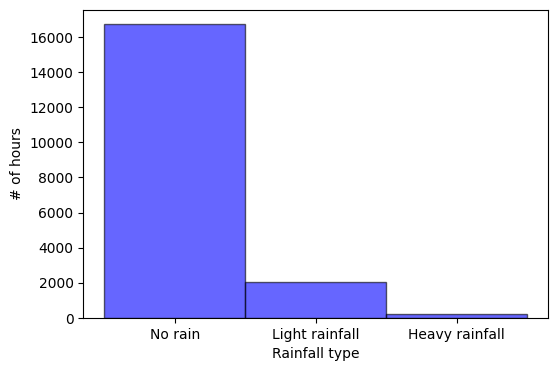

(array([16733,  2062,   217]), array([0., 1., 2., 3.]))

In [28]:
rain_counts, classes = np.histogram(processed_df_train['class'].values, bins=np.arange(0,processed_df_train['class'].max()+2))

plt.figure(figsize=(6,4))
# plt.title(f'Hours where it rained at least {rain_thresh} inches')
plt.bar(x=np.arange(0,processed_df_train['class'].max()+1), width=1, height=rain_counts, facecolor='blue', edgecolor='k', alpha=0.6)
plt.ylabel('# of hours')
plt.xticks(ticks=np.arange(0,processed_df_train['class'].max()+1), labels=['No rain', 'Light rainfall', 'Heavy rainfall'])
plt.xlabel('Rainfall type')
# plt.yscale('log')
plt.show()
rain_counts, classes

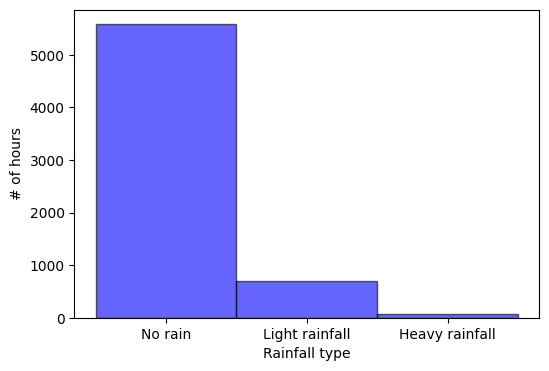

(array([5581,  690,   67]), array([0., 1., 2., 3.]))

In [29]:
rain_counts, classes = np.histogram(processed_df_val['class'].values, bins=np.arange(0,processed_df_train['class'].max()+2))

plt.figure(figsize=(6,4))
# plt.title(f'Hours where it rained at least {rain_thresh} inches')
plt.bar(x=np.arange(0,processed_df_train['class'].max()+1), width=1, height=rain_counts, facecolor='blue', edgecolor='k', alpha=0.6)
plt.ylabel('# of hours')
plt.xticks(ticks=np.arange(0,processed_df_train['class'].max()+1), labels=['No rain', 'Light rainfall', 'Heavy rainfall'])
plt.xlabel('Rainfall type')
# plt.yscale('log')
plt.show()
rain_counts, classes

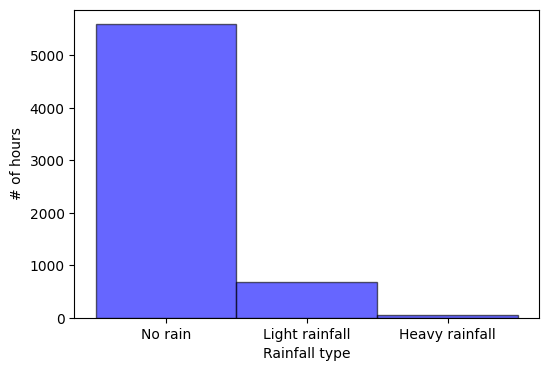

(array([5593,  685,   60]), array([0., 1., 2., 3.]))

In [30]:
rain_counts, classes = np.histogram(processed_df_test['class'].values, bins=np.arange(0,processed_df_train['class'].max()+2))

plt.figure(figsize=(6,4))
# plt.title(f'Hours where it rained at least {rain_thresh} inches')
plt.bar(x=np.arange(0,processed_df_train['class'].max()+1), width=1, height=rain_counts, facecolor='blue', edgecolor='k', alpha=0.6)
plt.ylabel('# of hours')
plt.xticks(ticks=np.arange(0,processed_df_train['class'].max()+1), labels=['No rain', 'Light rainfall', 'Heavy rainfall'])
plt.xlabel('Rainfall type')
# plt.yscale('log')
plt.show()
rain_counts, classes

In [31]:
processed_data_train = processed_df_train.values.astype(float)
processed_data_train = processed_data_train[~np.isnan(processed_data_train).any(axis=1)]
processed_data_train.shape

(18605, 6)

In [32]:
processed_data_val = processed_df_val.values.astype(float)
processed_data_val = processed_data_val[~np.isnan(processed_data_val).any(axis=1)]
processed_data_val.shape

(6213, 6)

In [33]:
processed_data_test = processed_df_test.values.astype(float)
processed_data_test = processed_data_test[~np.isnan(processed_data_test).any(axis=1)]
processed_data_test.shape

(6202, 6)

In [34]:
print(f'Data Shape: {data_arr.shape}')
print(f'Data Entry: [Month, Time of Day, Temperature, Relative Humidity, Pressure, Rain type]')

# Pre-Processed
print(data_arr[0])

# Post-Processed
print(processed_data_train[0])
print(processed_data_val[0])
print(processed_data_test[0])

Data Shape: (35610, 6)
Data Entry: [Month, Time of Day, Temperature, Relative Humidity, Pressure, Rain type]
['2020-05-01' '00:00' 55.6 1015.2 57.7 0.0]
[2.0000e+00 1.0000e+00 6.2900e+01 7.6100e+01 1.0136e+03 0.0000e+00]
[1.0000e+00 0.0000e+00 5.3300e+01 8.7300e+01 1.0069e+03 1.0000e+00]
[2.0000e+00 1.0000e+00 6.2800e+01 4.9300e+01 1.0135e+03 0.0000e+00]


In [35]:
x_data_train = processed_data_train[:, :processed_data_train.shape[1]-1]
y_data_train = processed_data_train[:, processed_data_train.shape[1]-1:].astype(int)
print(x_data_train[0], y_data_train[0])

[2.0000e+00 1.0000e+00 6.2900e+01 7.6100e+01 1.0136e+03] [0]


In [36]:
x_data_val = processed_data_val[:, :processed_data_train.shape[1]-1]
y_data_val = processed_data_val[:, processed_data_train.shape[1]-1:].astype(int)
print(x_data_val[0], y_data_val[0])

[1.0000e+00 0.0000e+00 5.3300e+01 8.7300e+01 1.0069e+03] [1]


In [37]:
x_data_test = processed_data_test[:, :processed_data_train.shape[1]-1]
y_data_test = processed_data_test[:, processed_data_train.shape[1]-1:].astype(int)
print(x_data_test[0], y_data_test[0])

[2.0000e+00 1.0000e+00 6.2800e+01 4.9300e+01 1.0135e+03] [0]


In [38]:
# # Assuming X is your feature matrix and y is your target vector
# # First split: train+val and test
# X_train_val, X_test, y_train_val, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

# # Second split: train and val
# X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

# # Now you have X_train, X_val, X_test, y_train, y_val, y_test
# print(f"Training set size: {X_train.shape[0]}")
# print(f"Validation set size: {X_val.shape[0]}")
# print(f"Test set size: {X_test.shape[0]}")

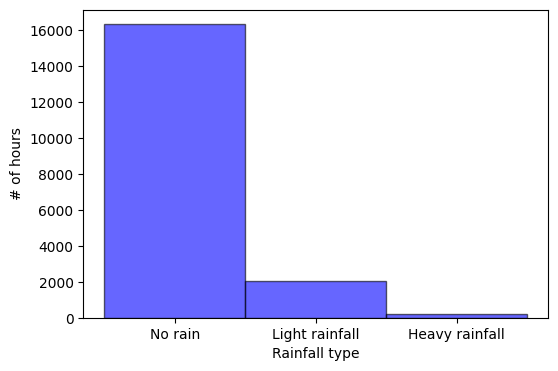

(array([16326,  2062,   217]), array([0, 1, 2, 3]))

In [39]:
rain_counts, classes = np.histogram(y_data_train, bins=np.arange(0,y_data_train.max()+2))

plt.figure(figsize=(6,4))
# plt.title(f'Hours where it rained at least {rain_thresh} inches')
plt.bar(x=np.arange(0,y_data_train.max()+1), width=1, height=rain_counts, facecolor='blue', edgecolor='k', alpha=0.6)
plt.ylabel('# of hours')
plt.xticks(ticks=np.arange(0,y_data_train.max()+1), labels=['No rain', 'Light rainfall', 'Heavy rainfall'])
plt.xlabel('Rainfall type')
# plt.yscale('log')
plt.show()
rain_counts, classes

In [40]:
smote = SMOTE(random_state = 42, sampling_strategy={0:10e3, 1:10e3, 2:10e3})
x_train_res, y_train_res = smote.fit_resample(x_data_train, y_data_train.ravel())

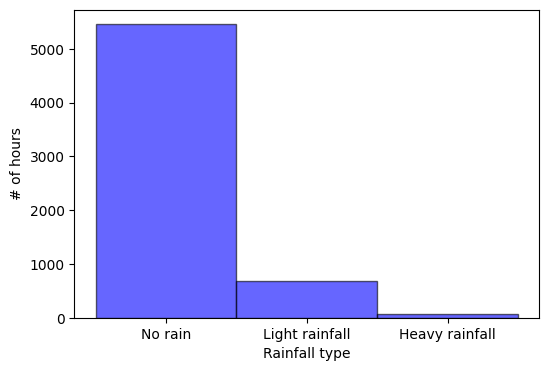

(array([5456,  690,   67]), array([0, 1, 2, 3]))

In [41]:
rain_counts, classes = np.histogram(y_data_val, bins=np.arange(0,y_data_train.max()+2))

plt.figure(figsize=(6,4))
# plt.title(f'Hours where it rained at least {rain_thresh} inches')
plt.bar(x=np.arange(0,y_data_train.max()+1), width=1, height=rain_counts, facecolor='blue', edgecolor='k', alpha=0.6)
plt.ylabel('# of hours')
plt.xticks(ticks=np.arange(0,y_data_train.max()+1), labels=['No rain', 'Light rainfall', 'Heavy rainfall'])
plt.xlabel('Rainfall type')
# plt.yscale('log')
plt.show()
rain_counts, classes

In [42]:
smote = SMOTE(random_state = 42, sampling_strategy={0:10e3, 1:10e3, 2:10e3})
x_val_res, y_val_res = smote.fit_resample(x_data_val, y_data_val.ravel())

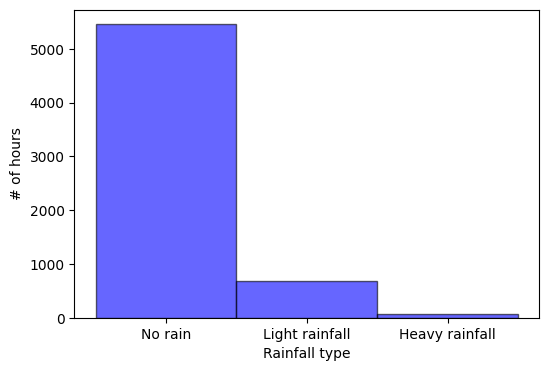

(array([5457,  685,   60]), array([0, 1, 2, 3]))

In [43]:
rain_counts, classes = np.histogram(y_data_test, bins=np.arange(0,y_data_train.max()+2))

plt.figure(figsize=(6,4))
# plt.title(f'Hours where it rained at least {rain_thresh} inches')
plt.bar(x=np.arange(0,y_data_train.max()+1), width=1, height=rain_counts, facecolor='blue', edgecolor='k', alpha=0.6)
plt.ylabel('# of hours')
plt.xticks(ticks=np.arange(0,y_data_train.max()+1), labels=['No rain', 'Light rainfall', 'Heavy rainfall'])
plt.xlabel('Rainfall type')
# plt.yscale('log')
plt.show()
rain_counts, classes

In [44]:
smote = SMOTE(random_state = 42, sampling_strategy={0:10e3, 1:10e3, 2:10e3})
x_test_res, y_test_res = smote.fit_resample(x_data_test, y_data_test.ravel()) 

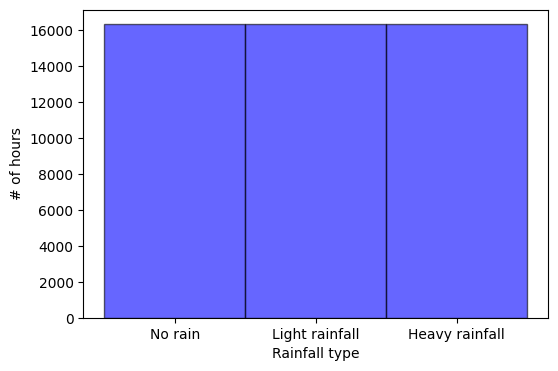

(array([16326, 16326, 16326]), array([0, 1, 2, 3]))

In [45]:
rain_counts, classes = np.histogram(y_train_res, bins=np.arange(0,y_train_res.max()+2))

plt.figure(figsize=(6,4))
# plt.title(f'Hours where it rained at least {rain_thresh} inches')
plt.bar(x=np.arange(0,y_train_res.max()+1), width=1, height=rain_counts, facecolor='blue', edgecolor='k', alpha=0.6)
# plt.xticks(np.arange(0,4))
plt.ylabel('# of hours')
plt.xticks(ticks=np.arange(0,y_train_res.max()+1), labels=['No rain', 'Light rainfall', 'Heavy rainfall'])
plt.xlabel('Rainfall type')
plt.show()
rain_counts, classes

In [46]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(x_train_res)
X_val_scaled = scaler.transform(x_val_res)

# Define the model
model = models.Sequential()

# Input layer
model.add(layers.Input(shape=(5,)))

# Hidden layers
model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dropout(0.5))

# Output layer
model.add(layers.Dense(4, activation='softmax'))  # Softmax for multiclass classification

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Learning rate reduction callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Early stopping callback
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Print model summary
model.summary()

Metal device set to: Apple M2

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2024-05-24 15:10:46.539300: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-24 15:10:46.540540: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                384       
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 4)                 132       
                                                                 
Total params: 2,596
Trainable params: 2,596
Non-trainable params: 0
_________________________________________________________________


In [47]:
X_train_scaled.shape, y_train_res.shape

((48978, 5), (48978,))

In [48]:
X_val_scaled.shape, y_val_res.shape

((16368, 5), (16368,))

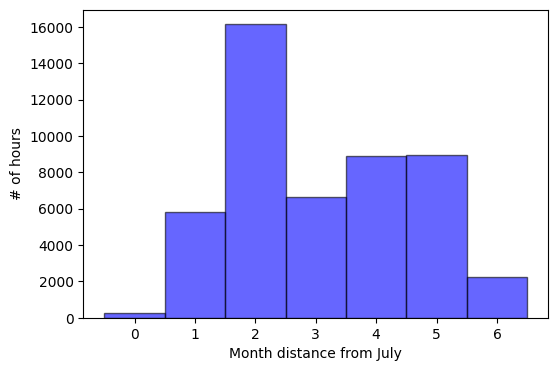

(array([  257,  5838, 16145,  6657,  8887,  8931,  2263]),
 array([0, 1, 2, 3, 4, 5, 6, 7]))

In [49]:
binwidth = 1
rain_counts, classes = np.histogram(x_train_res[:,0], bins=np.arange(0,7+binwidth,binwidth))

plt.figure(figsize=(6,4))
# plt.title(f'Hours where it rained at least {rain_thresh} inches')
plt.bar(x=np.arange(0,7,binwidth), width=binwidth, height=rain_counts, facecolor='blue', edgecolor='k', alpha=0.6)
# plt.xticks(np.arange(-1,1+binwidth,binwidth))
plt.ylabel('# of hours')
# plt.xticks(ticks=np.arange(0,4), labels=['No rain', 'Light rainfall', 'Mid rainfall', 'Heavy rainfall'])
plt.xlabel('Month distance from July')
plt.show()
rain_counts, classes

In [50]:
X_train_scaled

array([[-0.81606411, -0.55202879,  1.43799044, -0.12316521,  0.48209921],
       [-0.81606411,  0.38533838,  1.31383398, -3.07635235,  0.34711588],
       [-1.47734206, -0.55202879,  2.22017614, -1.96720603,  0.41460754],
       ...,
       [-0.35009619, -0.82888244, -0.33377994,  0.41316209,  0.67295791],
       [-0.7467744 , -0.65024754,  0.59751569,  0.41718621, -1.23271099],
       [ 0.5064918 ,  0.21889175, -0.41658173,  1.08849487, -0.79671077]])

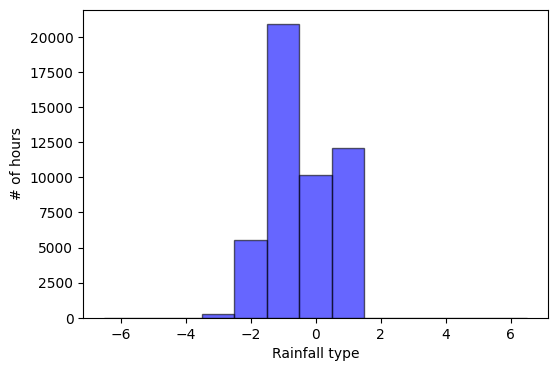

(array([    0,     0,     0,   257,  5534, 20905, 10153, 12129,     0,
            0,     0,     0,     0]),
 array([-6, -5, -4, -3, -2, -1,  0,  1,  2,  3,  4,  5,  6,  7]))

In [51]:
binwidth = 1
rain_counts, classes = np.histogram(X_train_scaled[:,0], bins=np.arange(-6,7+binwidth,binwidth))

plt.figure(figsize=(6,4))
# plt.title(f'Hours where it rained at least {rain_thresh} inches')
plt.bar(x=np.arange(-6,7,binwidth), width=binwidth, height=rain_counts, facecolor='blue', edgecolor='k', alpha=0.6)
# plt.xticks(np.arange(-1,1+binwidth,binwidth))
plt.ylabel('# of hours')
# plt.xticks(ticks=np.arange(0,4), labels=['No rain', 'Light rainfall', 'Mid rainfall', 'Heavy rainfall'])
plt.xlabel('Rainfall type')
plt.show()
rain_counts, classes

In [52]:
# Train the Model:
history = model.fit(
    X_train_scaled, y_train_res,
    epochs=100,
    batch_size=32,
    validation_data=(X_val_scaled, y_val_res),
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/100


2024-05-24 15:10:47.445451: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-05-24 15:10:47.731590: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


   1/1531 [..............................] - ETA: 15:09 - loss: 1.5696 - accuracy: 0.3438

1531/1531 [==============================] - ETA: 0s - loss: 0.9034 - accuracy: 0.5789

2024-05-24 15:11:03.058668: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1531/1531 [==============================] - 18s 11ms/step - loss: 0.9034 - accuracy: 0.5789 - val_loss: 0.8341 - val_accuracy: 0.6205 - lr: 0.0010
Epoch 2/100
1531/1531 [==============================] - 16s 10ms/step - loss: 0.8108 - accuracy: 0.6195 - val_loss: 0.8115 - val_accuracy: 0.6340 - lr: 0.0010
Epoch 3/100
1531/1531 [==============================] - 13s 8ms/step - loss: 0.7861 - accuracy: 0.6313 - val_loss: 0.8106 - val_accuracy: 0.6359 - lr: 0.0010
Epoch 4/100
1531/1531 [==============================] - 13s 8ms/step - loss: 0.7695 - accuracy: 0.6428 - val_loss: 0.8005 - val_accuracy: 0.6339 - lr: 0.0010
Epoch 5/100
1531/1531 [==============================] - 12s 8ms/step - loss: 0.7590 - accuracy: 0.6432 - val_loss: 0.7970 - val_accuracy: 0.5963 - lr: 0.0010
Epoch 6/100
1531/1531 [==============================] - 13s 8ms/step - loss: 0.7506 - accuracy: 0.6526 - val_loss: 0.7944 - val_accuracy: 0.6072 - lr: 0.0010
Epoch 7/100
1531/1531 [==============================] -

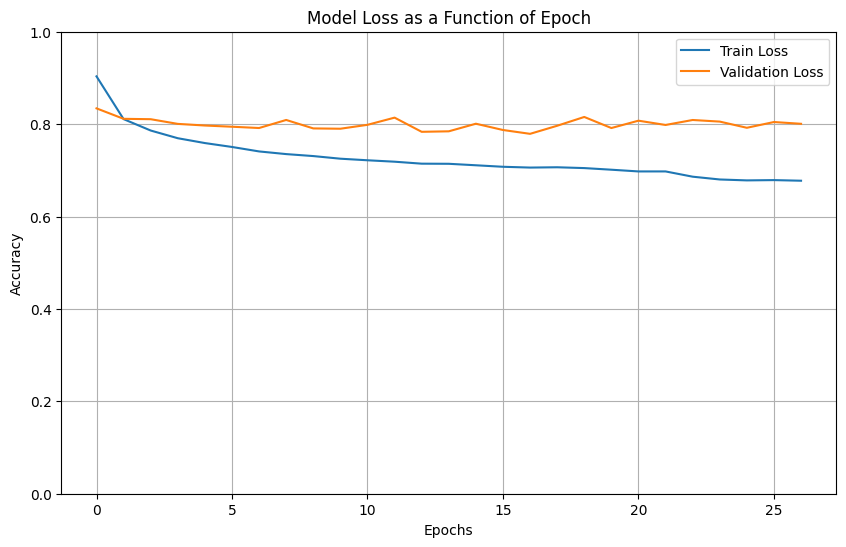

In [53]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the accuracy
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.title('Model Loss as a Function of Epoch')
plt.legend()
plt.grid(True)
plt.show()

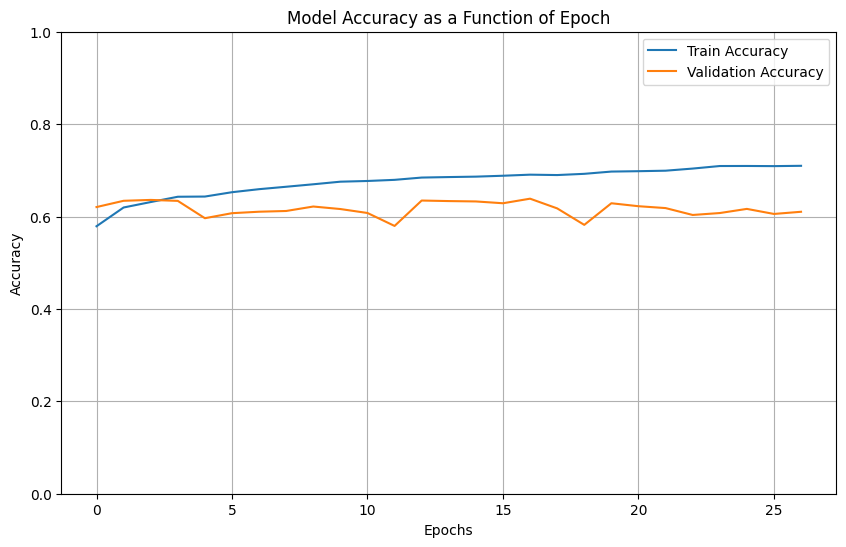

In [54]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plot the accuracy
plt.figure(figsize=(10, 6))
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.title('Model Accuracy as a Function of Epoch')
plt.legend()
plt.grid(True)
plt.show()

In [55]:
# Evaluation (Is it worth, the loss is quite high suggesting that either the model architecture is quite poor (likely) or 
# that we need to better preprocess our data such as rain (also likely))

In [56]:
X_test_scaled = scaler.transform(x_data_test)
predictions = model.predict(X_test_scaled)
model.evaluate(X_test_scaled, y_data_test.ravel().astype(float), verbose=2)

 56/194 [=======>......................] - ETA: 0s

2024-05-24 15:17:38.663484: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


194/194 [==============================] - 0s 2ms/step


2024-05-24 15:17:39.193886: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


194/194 - 1s - loss: 0.6952 - accuracy: 0.7017 - 982ms/epoch - 5ms/step


[0.695244550704956, 0.7017091512680054]

Confusion Matrix:
[[3941 1178  338]
 [ 132  376  177]
 [   3   22   35]]


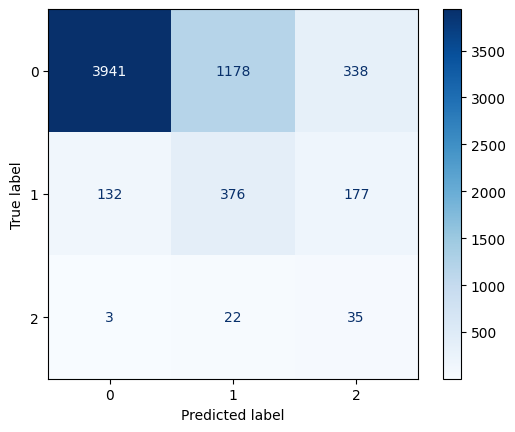

In [57]:
cm = confusion_matrix(y_data_test.ravel(), np.argmax(predictions,axis=1))

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2])
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [58]:
f1_score(y_data_test.ravel(), np.argmax(predictions,axis=1), average=None)

array([0.82681213, 0.3325962 , 0.1147541 ])

In [59]:
X_test_scaled = scaler.transform(x_test_res)
predictions = model.predict(X_test_scaled)
model.evaluate(X_test_scaled, y_test_res.astype(float), verbose=2)

512/512 [==============================] - 1s 2ms/step
512/512 - 2s - loss: 0.7960 - accuracy: 0.6473 - 2s/epoch - 4ms/step


[0.7960419654846191, 0.6473031640052795]

Confusion Matrix:
[[3941 1178  338]
 [ 948 2982 1527]
 [ 168 1615 3674]]


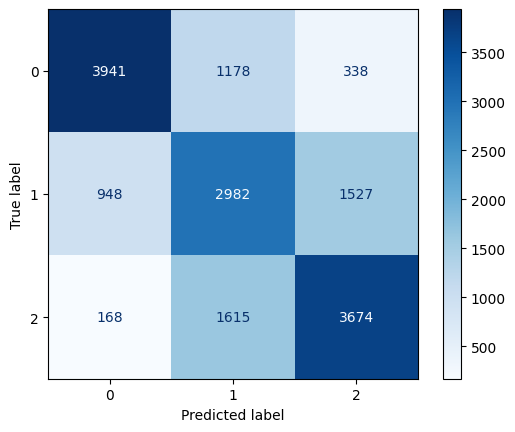

In [60]:
cm = confusion_matrix(y_test_res, np.argmax(predictions,axis=1))

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2])
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [61]:
f1_score(y_test_res, np.argmax(predictions,axis=1), average=None)

array([0.74966711, 0.53098291, 0.668243  ])